<a href="https://colab.research.google.com/github/royseto/langgraph-tutorials-royseto/blob/main/LangGraph_Quickstart_parts_1_2_royseto_20250211.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This colab notebook has Roy's work with the LangGraph Quickstart at https://langchain-ai.github.io/langgraph/tutorials/introduction/

# Setup

In [1]:
%%capture --no-stderr
%pip install -U langgraph langsmith langchain_anthropic

In [2]:
"""
The LangGraph Quickstart gets API keys interactively using `getpass`.
On colab, get them from colab secrets instead. Commenting this out.

import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("ANTHROPIC_API_KEY")
"""

'\nThe LangGraph Quickstart gets API keys interactively using `getpass`.\nOn colab, get them from colab secrets instead. Commenting this out.\n\nimport getpass\nimport os\n\n\ndef _set_env(var: str):\n    if not os.environ.get(var):\n        os.environ[var] = getpass.getpass(f"{var}: ")\n\n\n_set_env("ANTHROPIC_API_KEY")\n'

In [3]:
import os
from google.colab import userdata

os.environ["ANTHROPIC_API_KEY"] = userdata.get('ANTHROPIC_API_KEY')
os.environ["LANGSMITH_API_KEY"] = userdata.get('LANGSMITH_API_KEY')

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langgraph-quickstart"

# Part 1: Build a Basic Chatbot

In [4]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [5]:
from langchain_anthropic import ChatAnthropic

#llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm = ChatAnthropic(model="claude-3-5-sonnet-20241022")

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [6]:
graph_builder.add_edge(START, "chatbot")

In [7]:
graph_builder.add_edge("chatbot", END)

In [8]:
graph = graph_builder.compile()

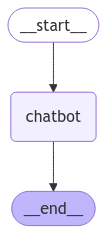

In [9]:
graph

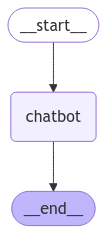

In [10]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [11]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: Tell me about egrets
Assistant: Egrets are large wading birds belonging to the heron family (Ardeidae). Here are some key facts about egrets:

Physical characteristics:
- Usually white plumage
- Long legs and necks
- Sharp, pointed beaks
- Graceful appearance
- Many species have decorative plumes during breeding season

Common species include:
1. Great Egret
2. Snowy Egret
3. Cattle Egret
4. Little Egret

Habitat:
- Wetlands
- Marshes
- Swamps
- Coastal areas
- Rivers and lakes

Behavior:
- Wade in shallow water to hunt
- Feed on fish, amphibians, small reptiles, insects, and crustaceans
- Often nest in colonies
- Build platform nests in trees or shrubs
- Many species are migratory

Historical significance:
- Their plumes were once highly valued in the fashion industry
- This led to severe population decline in the late 1800s
- Conservation efforts helped populations recover
- They are now protected in many countries

Egrets play important roles in their ecosystems and are often 

# Part 2: 🛠️ Enhancing the Chatbot with Tools

For Tavily hello world notebook, see https://colab.research.google.com/drive/1P16Y23P-1uSGLkQI50y0IUc3FdYgBGTW

"Tavily Search API is a search engine optimized for LLMs, aimed at efficient, quick and persistent search results." - https://docs.tavily.com/docs/welcome

In [12]:
%%capture --no-stderr
%pip install -U tavily-python langchain_community

In [13]:
import os
from google.colab import userdata
os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')

In [14]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://medium.com/@kbdhunga/beginners-guide-to-langgraph-understanding-state-nodes-and-edges-part-1-897e6114fa48',
  'content': "Beginner’s Guide to LangGraph: Understanding State, Nodes, and Edges — Part 1 | by Kamal Dhungana | Medium Beginner’s Guide to LangGraph: Understanding State, Nodes, and Edges — Part 1 LangGraph — State, Node and Edge Explained Mainly, we will focus on various components of LangGraph: State, Node, and Edges, and how to build a complete graph from these components. Once we understand these components, we will be able to build relatively complex LangGraph-based agents. Each node represents a specific function or operation that processes the current state. Nodes can perform computations, modify the state, or generate outputs based on the input they receive. Follow 1.2K Followers Data scientist with a passion for AI, Regularly blogging about LLM and OpenAI's innovations,Sharing insights for AI community growth Follow"},
 {'url': 'https://blog.langchain

In [15]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


#llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm = ChatAnthropic(model="claude-3-5-sonnet-20241022")
# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

In [16]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [17]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

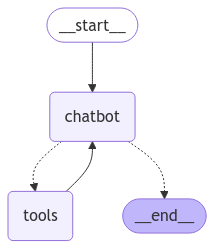

In [18]:
graph

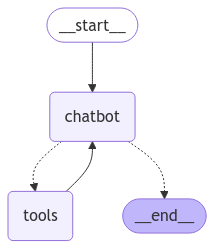

In [19]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [20]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: Who are the investors in stargate
Assistant: [{'text': 'Let me search for information about Stargate and its investors.', 'type': 'text'}, {'id': 'toolu_01Qq8u13piPUPpTwAfoeWNUX', 'input': {'query': 'Stargate Protocol investors funding rounds'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Assistant: [{"url": "https://tracxn.com/d/companies/stargate/__GPlam86tqPbRYnNxUmkYuvkNy4WkpBeJSFpocPX0ka4", "content": "Stargate has 5 institutional investors including Wave Financial, Delphi Ventures and Ryze Labs. View details of Stargate funding rounds and"}, {"url": "https://www.crunchbase.com/organization/stargate-d882", "content": "Stargate has 3 investors including Banana Capital and Cynegetic Investment Management . When was the last funding round for Stargate ? Stargate closed its"}]
Assistant: [{'text': 'Let me search for more specific details.', 'type': 'text'}, {'id': 'toolu_0121xFzsK6V4YQ4qGK5rvEyN', 'input': {'query': 'Stargate Protocol Wave Financial Delphi Venture

Could do later: Replace the builtin functions for our handwritten ones per the [tutorial instructions](https://langchain-ai.github.io/langgraph/tutorials/introduction/) at the end of part 2.